In [1]:
import sys
import os
import numpy as np

def load_dataset():
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import trange, tqdm

In [3]:
x = X_train[1154, 0]

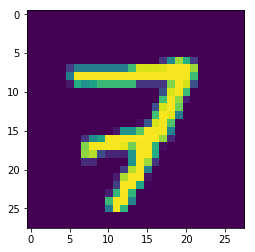

In [4]:
plt.imshow(x)

## The viewport

In [5]:
g_x, g_y, var, delta, n = 10, 10, 1, .5, 4

In [6]:
a, b = [np.arange(i).reshape(1, -1) for i in x.shape]
grid = np.arange(n).reshape(-1, 1)

In [7]:
mu_x = g_x + (grid - (n + 1) / 2) * delta
mu_y = g_y + (grid - (n + 1) / 2) * delta

In [8]:
Fx = np.exp(-(a - mu_x) ** 2 / (2 * var))
Fy = np.exp(-(b - mu_y) ** 2 / (2 * var))
Fx /= Fx.sum()
Fy /= Fy.sum()

In [11]:
def compress(x, g_x, g_y, var, delta, n):
    a, b = [np.arange(i).reshape(1, -1) for i in x.shape]
    grid = np.arange(n).reshape(-1, 1)
    
    mu_x = g_x + (grid - (n + 1) / 2) * delta
    mu_y = g_y + (grid - (n + 1) / 2) * delta
    
    Fx = np.exp(-(a - mu_x) ** 2 / (2 * var))
    Fy = np.exp(-(b - mu_y) ** 2 / (2 * var))
    Fx /= Fx.sum()
    Fy /= Fy.sum()
    
    return Fx @ x @ Fy.T

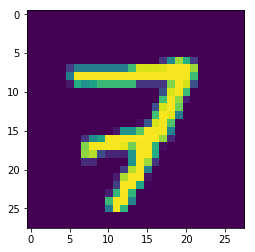

In [12]:
plt.imshow(x)

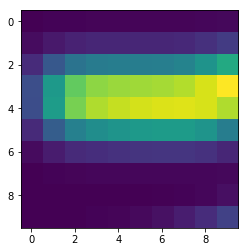

In [16]:
c = compress(x, 10, 10, 1, 1, 10)
d = compress(c, 5, 5, 1 / 5, 1, 28)
plt.imshow(c)

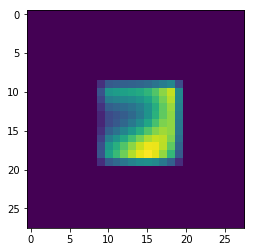

In [11]:
plt.imshow(d)

## Pytorch implementation

In [3]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

In [4]:
def bin_crossentropy(target, predicted):
    return -torch.sum(target * torch.log(predicted + 1e-10) + (1 - target) * torch.log(1 - predicted + 1e-10))

def kl_divergence(mu, log_std):
    div = 0
    for m, s in zip(mu, log_std):
#         div += .5 * (m ** 2 + torch.exp(2 * s) - 2 * s - 1).sum(dim=1)
        div += .5 * (m ** 2 + torch.exp(2 * s) - 2 * s - 1).sum(dim=1)
    return torch.sum(div)

In [5]:
def minibatches(inputs, targets, batch_size, shuffle=True, strict=True):
    assert len(inputs) == len(targets)

    last = batch_size - 1 if strict else 0
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - last, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]

### Without attention

In [90]:
class DRAW_(nn.Module):
    def __init__(self, image_size, encoder_size, 
                 decoder_size, sampler_size, length):
        super().__init__()
        
        
        self.encoder = nn.LSTMCell(2 * image_size**2 + decoder_size, encoder_size)
        self.mu = nn.Linear(encoder_size, sampler_size) 
        self.log_std = nn.Linear(encoder_size, sampler_size)      
        self.decoder = nn.LSTMCell(sampler_size, decoder_size)
        self.writer = nn.Linear(decoder_size, image_size ** 2)
        
        self.image_size = image_size
        self.encoder_size = encoder_size
        self.decoder_size = decoder_size
        self.length = length
    
    def forward(self, x):
        batch = x.size(0)
        
        result = []
        mu, log_std = [], []
        c = Variable(torch.zeros(x.size())).cuda()
        h_enc = Variable(torch.zeros(batch, self.encoder_size)).cuda()
        c_enc = Variable(torch.zeros(batch, self.encoder_size)).cuda()
        h_dec = Variable(torch.zeros(batch, self.decoder_size)).cuda()
        c_dec = Variable(torch.zeros(batch, self.decoder_size)).cuda()
        
        for t in range(self.length):
            x_hat = x - F.sigmoid(c)
            r = self.read(x, x_hat, h_dec).view(batch, -1)
            r = torch.cat((r, h_dec), 1)
            h_enc, c_enc = self.encoder(r, (h_enc, c_enc))
            
            z, mean, l_std = self.sample(h_enc)
            mu.append(mean)
            log_std.append(l_std)
            
            h_dec, c_dec = self.decoder(z, (h_dec, c_dec))
            c += self.write(h_dec).view(batch, self.image_size, self.image_size)
            result.append(F.sigmoid(c))
        return result, mu, log_std
            
    def sample(self, state):
        mu = self.mu(state)
        log_std = self.log_std(state)
        eps = Variable(torch.randn(*mu.size())).cuda()
        return mu + eps * torch.exp(log_std), mu, log_std
    
    def read(self, x, x_hat, state):
        return torch.cat((x, x_hat), 1)

In [97]:
draw = DRAW_(28, 500, 500, 10, 10).cuda()
optimizer = torch.optim.Adam(draw.parameters(), lr=1e-3)
losses = []

In [99]:
epochs = 15
batch_size = 1000
freq = 5 #2000 / batch_size

In [100]:
for epoch in range(epochs):
    ep = 'Epoch %d: ' % epoch
    mean_loss = 0
    step = 0
    bar = tqdm(minibatches(X_train, y_train, batch_size=batch_size), leave=False)
    for x, _ in bar:
        x = Variable(torch.from_numpy(x[:, 0])).cuda()

        z, mu, log_std = draw(x)
        y = z[-1]
        loss = bin_crossentropy(x, y) + kl_divergence(mu, log_std)
        mean_loss += loss.cpu().data[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step += 1
        if step >= freq:
            losses.append(mean_loss / step)
            bar.set_description(ep + str(losses[-1]))
            mean_loss = step = 0
    if step:
        losses.append(mean_loss / step)
        bar.set_description(ep + str(losses[-1]))

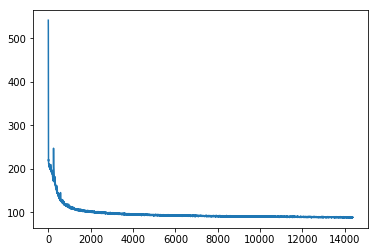

In [1120]:
plt.plot(losses)

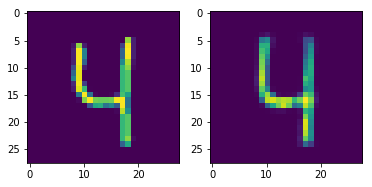

In [1122]:
ax = plt.subplots(1, 2)[1]
idx = 6
ax[0].imshow(x[idx].cpu().data.numpy(), interpolation='none')
ax[1].imshow(z[-1][idx].cpu().data.numpy(), interpolation='none')

In [1123]:
c = [i[idx].cpu().data.numpy() for i in z]

In [39]:
from matplotlib.animation import FuncAnimation

def animate(data, output_name=None, fps=30, size=None, writer='imagemagick', cmap=None, vmin=None, vmax=None):
    if size:
        fig = plt.figure(figsize=size)
    else:
        fig = plt.figure()

    im = plt.imshow(data[0], animated=True, cmap=cmap, vmin=vmin, vmax=vmax)

    def update(i):
        im.set_data(data[i])
        if vmin is None or vmax is None:
            im.autoscale()
        return im,

    plt.tight_layout(pad=.1, w_pad=.1, h_pad=.1)

    animation = FuncAnimation(fig, func=update, frames=len(data), interval=20, blit=True)
    if output_name is None:
        return animation
    animation.save(output_name, fps=fps, writer=writer)

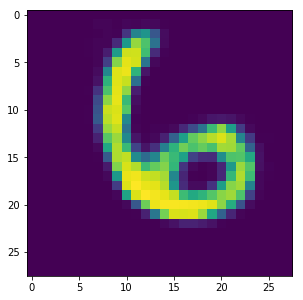

In [136]:
animate(c, 'draw.gif', fps=2)

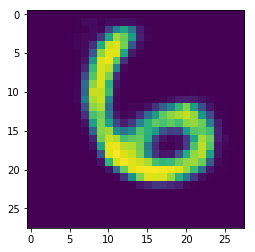

In [131]:
plt.imshow(c[8], interpolation='none')

### With attention

In [6]:
# pytorch doesn't support broadcasting yet
import operator

def unit_prefix(x, n=1):
    for i in range(n): x = x.unsqueeze(0)
    return x

def align(x, y, start_dim=2):
    xd, yd = x.dim(), y.dim()
    if xd > yd: y = unit_prefix(y, xd - yd)
    elif yd > xd: x = unit_prefix(x, yd - xd)

    xs, ys = list(x.size()), list(y.size())
    nd = len(ys)
    for i in range(start_dim, nd):
        td = nd-i-1
        if   ys[td]==1: ys[td] = xs[td]
        elif xs[td]==1: xs[td] = ys[td]
    return x.expand(*xs), y.expand(*ys)

def dot(x, y):
    assert(1<y.dim()<5)
    x, y = align(x, y)
    
    if y.dim() == 2: return x.mm(y)
    elif y.dim() == 3: return x.bmm(y)
    else:
        xs,ys = x.size(), y.size()
        res = torch.zeros(*(xs[:-1] + (ys[-1],)))
        for i in range(xs[0]): res[i].baddbmm_(x[i], (y[i]))
        return res
    
def aligned_op(x,y,f):
    x, y = align(x,y,0)
    return f(x, y)

def add(x, y): return aligned_op(x, y, operator.add)
def sub(x, y): return aligned_op(x, y, operator.sub)
def mul(x, y): return aligned_op(x, y, operator.mul)
def div(x, y): return aligned_op(x, y, operator.truediv)

In [42]:
class DRAW(nn.Module):
    def __init__(self, encoder_size, decoder_size, sampler_size, length, 
                 window_size):
        super().__init__()
        
        self.encoder = nn.LSTMCell(2 * window_size**2 + decoder_size, 
                                   encoder_size)
        self.mu = nn.Linear(encoder_size, sampler_size) 
        self.log_std = nn.Linear(encoder_size, sampler_size)      
        self.decoder = nn.LSTMCell(sampler_size, decoder_size)
        self.read_params = nn.Linear(decoder_size, 5)
        self.write_params = nn.Linear(decoder_size, 5)
        self.writer = nn.Linear(decoder_size, window_size ** 2)
        
        self.window_size = window_size
        self.encoder_size = encoder_size
        self.decoder_size = decoder_size
        self.length = length
        self.eps = 1e-10
    
    def forward(self, x):
        batch = x.size(0)
        
        result = []
        mu, log_std = [], []
        c = Variable(torch.zeros(x.size())).cuda()
        h_enc = Variable(torch.zeros(batch, self.encoder_size)).cuda()
        c_enc = Variable(torch.zeros(batch, self.encoder_size)).cuda()
        h_dec = Variable(torch.zeros(batch, self.decoder_size)).cuda()
        c_dec = Variable(torch.zeros(batch, self.decoder_size)).cuda()
        
        for t in range(self.length):
            x_hat = x - F.sigmoid(c)
            r = self.read(x, x_hat, h_dec).view(batch, -1)
            r = torch.cat((r, h_dec), 1)
            h_enc, c_enc = self.encoder(r, (h_enc, c_enc))
            
            z, mean, l_std = self.sample(h_enc)
            mu.append(mean)
            log_std.append(l_std)
            
            h_dec, c_dec = self.decoder(z, (h_dec, c_dec))
            c += self.write(h_dec, x.size(1)).view(x.size())
            result.append(F.sigmoid(c))
        return result, mu, log_std
            
    def sample(self, state):
        mu = self.mu(state)
        log_std = self.log_std(state)
        eps = Variable(torch.randn(*mu.size())).cuda()
        return mu + eps * torch.exp(log_std), mu, log_std
    
    def read(self, x, x_hat, state):
        params = self.read_params(state).split(1, 1)
        Fx, Fy, gamma = self.get_matrices(*params, x.size(1))
        Fy = Fy.transpose(2, 1)
        Fxx = torch.bmm(Fx, x)
        x = mul(torch.bmm(Fxx, Fy), gamma)
        Fxx = torch.bmm(Fx, x_hat)
        x_hat = mul(torch.bmm(Fxx, Fy), gamma)
        return torch.cat((x, x_hat), 1)
    
    def write(self, state, image_size):
        x = self.writer(state).view(state.size(0), self.window_size, self.window_size)
        params = self.write_params(state).split(1, 1)
        Fx, Fy, gamma = self.get_matrices(*params, image_size)
        Fx = Fx.transpose(2, 1)
        Fxx = torch.bmm(Fx, x)
        x = mul(torch.bmm(Fxx, Fy), gamma)
        return x
        
    def get_matrices(self, g_x, g_y, log_var, log_delta, log_gamma, image_size):
        g_x = (g_x + 1) * (image_size + 1) / 2
        g_y = (g_y + 1) * (image_size + 1) / 2
        delta = (image_size - 1) / (self.window_size) * torch.exp(log_delta)
        
#         g_x = F.sigmoid(g_x) * image_size
#         g_y = F.sigmoid(g_y) * image_size
#         delta = image_size / self.window_size * F.sigmoid(delta)
        gamma = torch.exp(log_gamma).view(-1, 1, 1)
        var = torch.exp(log_var).view(-1, 1, 1)

        grid = Variable(torch.range(0, self.window_size - 1).view(1, -1)).cuda()

        mu_x = add(g_x, mul(grid - (self.window_size - 1) / 2, delta))
        mu_y = add(g_y, mul(grid - (self.window_size - 1) / 2, delta))
        mu_x = mu_x.view(-1, self.window_size, 1)
        mu_y = mu_x.view(-1, self.window_size, 1)

        a = Variable(torch.range(0, image_size - 1).view(1, 1, -1)).cuda()
        b = Variable(torch.range(0, image_size - 1).view(1, 1, -1)).cuda()

        Fx = torch.exp(div(-sub(a, mu_x) ** 2, (2 * var)))
        Fy = torch.exp(div(-sub(b, mu_y) ** 2, (2 * var)))
        Fx = div(Fx, Fx.sum(dim=2) + self.eps)
        Fy = div(Fy, Fy.sum(dim=2) + self.eps)
        return Fx, Fy, gamma

In [8]:
draw = DRAW(encoder_size=500, decoder_size=500, sampler_size=10, length=25, window_size=5).cuda()
losses = []
# criterion = F.binary_cross_entropy
criterion = bin_crossentropy

In [9]:
lr = 1e-3
optimizer = torch.optim.Adam(draw.parameters(), lr=lr)

In [30]:
epochs = 25
batch_size = 1000
freq = 2000 / batch_size

In [31]:
del bar

In [32]:
for epoch in range(epochs):
    ep = 'Epoch %d: ' % epoch
    mean_loss = 0
    step = 0
    bar = tqdm(minibatches(X_train, y_train, batch_size=batch_size), leave=False, 
               total=(epochs-epoch) * len(X_train) // batch_size)
    for x, _ in bar:
        x = Variable(torch.from_numpy(x[:, 0])).cuda()

        z, mu, log_std = draw(x)
        y = z[-1]
        loss = (criterion(x, y) + kl_divergence(mu, log_std)) / batch_size
        mean_loss += loss.cpu().data[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         nn.utils.clip_grad_norm(draw.parameters(), 100)
#         for p in draw.parameters():
#             p.data.add_(-lr, p.grad.data)
        
        step += 1
        if step >= freq:
            losses.append(mean_loss / step)
            bar.set_description(ep + str(losses[-1]))
            mean_loss = step = 0
    if step:
        losses.append(mean_loss / step)
        bar.set_description(ep + str(losses[-1]))

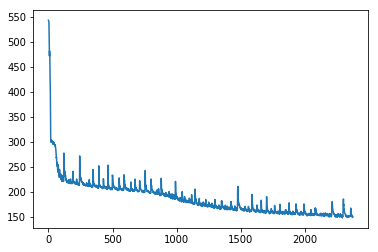

In [33]:
plt.plot(losses)

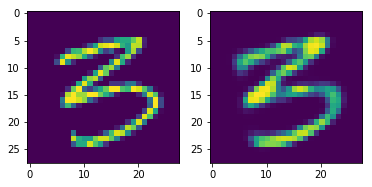

In [83]:
ax = plt.subplots(1, 2)[1]
idx = 200
ax[0].imshow(x[idx].cpu().data.numpy(), interpolation='none')
ax[1].imshow(z[-1][idx].cpu().data.numpy(), interpolation='none')

In [84]:
c = [i[idx].cpu().data.numpy() for i in z]

In [ ]:
animate(c, 'sh.gif', fps=12)

In [98]:
source = np.array([rotate(X_test[0, 0], i, (1,0), reshape=False) for i in range(0, 181, 1)])
pred = draw(Variable(torch.from_numpy(source)).cuda())[0]

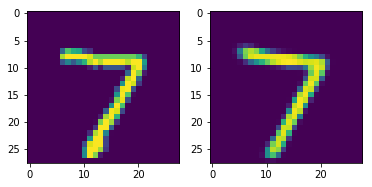

In [99]:
ax = plt.subplots(1, 2)[1]
idx = 0
ax[0].imshow(source[idx], interpolation='none')
ax[1].imshow(pred[-1][idx].cpu().data.numpy(), interpolation='none')

In [101]:
# c = [i[idx].cpu().data.numpy() for i in pred]
c = [pred[-1][idx].cpu().data.numpy() for idx in range(len(source))]

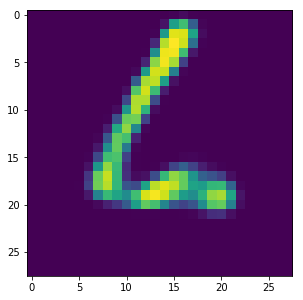

In [102]:
animate(c, 'transform.gif', fps=10)

## Classification

In [7]:
class DRAWClassifier(nn.Module):
    def __init__(self, encoder_size, attention_size, length, window_size, num_classes):
        super().__init__()
        
        self.encoder = nn.LSTMCell(window_size**2 + attention_size, encoder_size)
        self.attention = nn.LSTMCell(encoder_size, attention_size)
        self.read_params = nn.Linear(attention_size, 5)
        self.classifier = nn.Sequential(
            nn.Linear(encoder_size, encoder_size // 4),
            nn.ReLU(),
            nn.Linear(encoder_size // 4, encoder_size // 8),
            nn.ReLU(),
            nn.Linear(encoder_size // 8, num_classes),
            nn.ReLU(),
        )
        
        self.window_size = window_size
        self.encoder_size = encoder_size
        self.attention_size = attention_size
        self.length = length
        self.eps = 1e-10
    
    def forward(self, x):
        batch = x.size(0)
        
        c = Variable(torch.zeros(x.size())).cuda()
        h_enc = Variable(torch.zeros(batch, self.encoder_size)).cuda()
        c_enc = Variable(torch.zeros(batch, self.encoder_size)).cuda()
        h_att = Variable(torch.zeros(batch, self.attention_size)).cuda()
        c_att = Variable(torch.zeros(batch, self.attention_size)).cuda()
        
        for t in range(self.length):
            r = self.read(x, h_att).view(batch, -1)
            r = torch.cat((r, h_att), 1)
            h_enc, c_enc = self.encoder(r, (h_enc, c_enc))
            h_att, c_att = self.attention(h_enc, (h_att, c_att))
            
        c = F.log_softmax(self.classifier(h_enc))
        return c
             
    def read(self, x, state):
        params = self.read_params(state).split(1, 1)
        Fx, Fy, gamma = self.get_matrices(*params, x.size(1), x.size(2))
        Fy = Fy.transpose(2, 1)
        Fxx = torch.bmm(Fx, x)
        x = mul(torch.bmm(Fxx, Fy), gamma)
        return x
        
    def get_matrices(self, g_x, g_y, log_var, log_delta, log_gamma, image_width, image_height):
        g_x = (g_x + 1) * (image_width + 1) / 2
        g_y = (g_y + 1) * (image_height + 1) / 2
        delta = (max(image_width, image_height) - 1) / (self.window_size) * torch.exp(log_delta)
        gamma = torch.exp(log_gamma).view(-1, 1, 1)
        var = torch.exp(log_var).view(-1, 1, 1)

        grid = Variable(torch.range(0, self.window_size - 1).view(1, -1)).cuda()

        mu_x = add(g_x, mul(grid - (self.window_size - 1) / 2, delta))
        mu_y = add(g_y, mul(grid - (self.window_size - 1) / 2, delta))
        mu_x = mu_x.view(-1, self.window_size, 1)
        mu_y = mu_x.view(-1, self.window_size, 1)

        a = Variable(torch.range(0, image_width - 1).view(1, 1, -1)).cuda()
        b = Variable(torch.range(0, image_height - 1).view(1, 1, -1)).cuda()

        Fx = torch.exp(div(-sub(a, mu_x) ** 2, (2 * var)))
        Fy = torch.exp(div(-sub(b, mu_y) ** 2, (2 * var)))
        Fx = div(Fx, Fx.sum(dim=2) + self.eps)
        Fy = div(Fy, Fy.sum(dim=2) + self.eps)
        return Fx, Fy, gamma

In [8]:
from scipy.ndimage import zoom

In [61]:
X_zoom = np.array([zoom(x, 4) for x in X_train[:, 0]])

In [62]:
draw = DRAWClassifier(encoder_size=100, attention_size=100, length=60, window_size=5, num_classes=10).cuda()
losses = []
criterion = nn.NLLLoss()
# criterion = bin_crossentropy

In [63]:
lr = 1e-4
optimizer = torch.optim.Adam(draw.parameters(), lr=lr)

In [102]:
epochs = 15
batch_size = 1000
freq = 2000 / batch_size

In [141]:
for epoch in range(epochs):
    ep = 'Epoch %d: ' % epoch
    mean_loss = 0
    step = 0
    bar = tqdm(minibatches(X_zoom, y_train, batch_size=batch_size), leave=False, 
               total=(epochs-epoch) * len(X_train) // batch_size)
    for x, y in bar:
#         some augmentation:
#         w, h = np.split(np.random.randint(0, 50, size=4), 2)
#         d = 32
#         w, h = np.random.randint(0, d + 1, 2)
#         x = np.pad(x[:, 0], ((0, 0), (w, d - w), (h, d - h)), mode='constant')
        
        x = Variable(torch.from_numpy(x)).cuda()
        y = Variable(torch.from_numpy(y.astype('long'))).cuda()

        y_pred = draw(x)
        loss = criterion(y_pred, y)
        mean_loss += loss.cpu().data[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step += 1
        if step >= freq:
            losses.append(mean_loss / step)
            bar.set_description(ep + str(losses[-1]))
            mean_loss = step = 0
    if step:
        losses.append(mean_loss / step)
        bar.set_description(ep + str(losses[-1]))

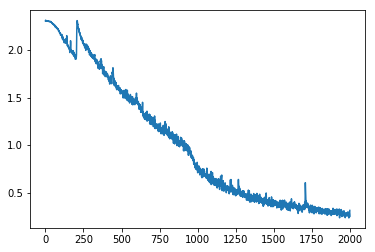

In [142]:
plt.plot(losses)

9


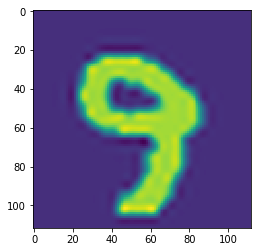

In [206]:
idx = np.random.randint(0, len(y_pred))
print(np.argmax(y_pred[idx].cpu().data.numpy()))
plt.imshow(x[idx].cpu().data.numpy(), interpolation='none')

In [207]:
torch.save(draw, 'draw_4x')

/home/mount/neuro-t01-ssd/home/memax/env36/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type DRAWClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
